# CoverMyMeds Data Science Project: EDA

## Project Objectives

This project has three primary goals:

1. Predict the patient's expected cost of a prescription drug (DV: `patient_pay`)

2. Predict the formulary status of the medication on each insurance plan (DV: `rejected`)

  * some drugs have a low status and others have a higher status and the higher ones are more likely to be rejected.

3. Develop a method for grouping similar medications together so patients can compare all options (DV: `drug`)

  * possibly an unsupervised method with no outcome

## Import and Clean the Data

In [2]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot, set_style
import seaborn as sns
# testing 1, 2, 3
set_style("whitegrid")

In [15]:
from google.colab 
import drivedrive.mount('/content/drive')

SyntaxError: invalid syntax (<ipython-input-15-4259fd0c0e35>, line 1)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/May22-Galileo/cmm_erdos_2022/pharmacy_tx.csv')
df.head()

In [3]:
df = pd.read_csv('pharmacy_tx.csv')
df.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00


There are several categories of values in these columns. 

## Patient Payments

[Text(0.5, 0, ''), Text(0, 0.5, '')]

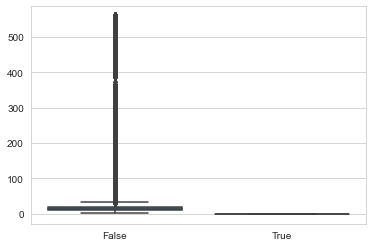

In [12]:
sns.boxplot(x='rejected', y='patient_pay', data=df).set(xlabel=None, ylabel=None)

In [13]:
#Check balance of reject/non-reject, What percent of prescription were accepted for reimbursement?
rejected = df[df.rejected == False]
pct_reject = len(rejected)/len(df.patient_pay)
percentage = "{:.1%}". format(pct_reject)
print("Percent Accepted is", percentage)

Percent Accepted is 92.2%


Since none of the rejected rows have a copay we will only look at the rows that have a copay to predict copay.  This combined with a model for predicting whether or not a prescription will be accepted will give the prediction for the copayment for the patient.

In [5]:
df_accepted_total = df.loc[df['rejected']==False]
df_rejected=df.loc[df['rejected'] == True]

In [6]:
random.seed(104)
df_accepted, df_accepted_test = train_test_split(df_accepted_total.copy(),
                                          shuffle=True,
                                          random_state=440,
                                          test_size=.2)

In [18]:
df \
    .groupby("rejected") \
    .aggregate({"patient_pay": ["mean", np.std, "min", "count"]})

patient_pay                          
                mean        std  min     count
rejected                                      
False       26.09971  40.514176  3.4  12823384
True         0.00000   0.000000  0.0   1086860

C:\Users\papri\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Density')

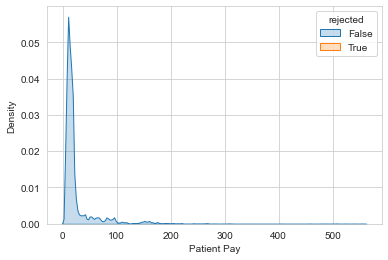

In [19]:
sns.kdeplot(
    x = "patient_pay",
    hue = "rejected",
    fill = "rejected",
    data = df
)

plt.xlabel("Patient Pay")
plt.ylabel("Density")

Data is very right skewed. Also, `patient_pay` is positive only with values of zero, so a hurdle-Gamma model may be appropriate. The payments for patients with rejected claims hover near zero while the payments for patients with approved claims max out at around 500. 

Patients with rejected claims pay nothing and there is no deviation in that amount. Patients with approved claims pay \$26 on average with a standard deviation about about \$40. 

## Copayments Over Time

Is there variation in payments over time? Since our data spans the course of one year, we can look for monthly (or daily) variation. Additionally, there are no copayments of zero. This suggests that removing rejected claims from the data may be useful since these observations will provide no predictive benefit.

In [20]:
# create month and year varaibles
df = \
    df \
    .assign(
        tx_month = pd.DatetimeIndex(df["tx_date"]).month,
        tx_year = pd.DatetimeIndex(df["tx_date"]).year
    )

Text(0, 0.5, 'Log(Patient Copayment)')

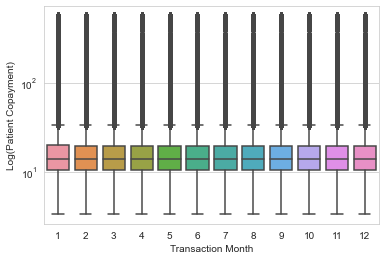

In [21]:
sns.boxplot(
    x = "tx_month",
    y = "patient_pay",
    data = df[df.rejected == False]
).set_yscale("log")
plt.xlabel("Transaction Month")
plt.ylabel("Log(Patient Copayment)")

Copayment amounts are very stable over the year. Is there variation within days?

Text(0, 0.5, 'Log(Patient Copayment)')

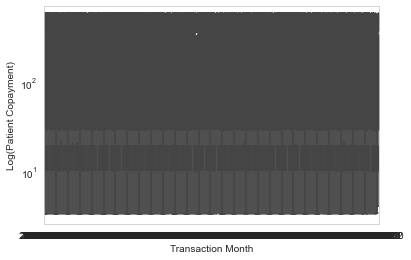

In [22]:
sns.boxplot(
    x = "tx_date",
    y = "patient_pay",
    data = df_accepted[df_accepted.rejected == False]
).set_yscale("log")
plt.xlabel("Transaction Month")
plt.ylabel("Log(Patient Copayment)")

Copayment amounts are very stable within months as well. Overall, there doesn't seem to be any temporal variation in patient copayments. 

## Copayments by Location

Next, we examine the level of variation in copayments across pharmacies. 

In [23]:
col_var = 'pharmacy'
df_accepted[col_var] = [val.split('#')[-1] for val in df_accepted[col_var]]
df_accepted[col_var]
pharmacy_vars = df_accepted[col_var].unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57]),
 [Text(0, 0, '42'),
  Text(1, 0, '0'),
  Text(2, 0, '57'),
  Text(3, 0, '12'),
  Text(4, 0, '5'),
  Text(5, 0, '23'),
  Text(6, 0, '28'),
  Text(7, 0, '56'),
  Text(8, 0, '9'),
  Text(9, 0, '6'),
  Text(10, 0, '34'),
  Text(11, 0, '29'),
  Text(12, 0, '31'),
  Text(13, 0, '39'),
  Text(14, 0, '38'),
  Text(15, 0, '33'),
  Text(16, 0, '18'),
  Text(17, 0, '15'),
  Text(18, 0, '51'),
  Text(19, 0, '43'),
  Text(20, 0, '10'),
  Text(21, 0, '4'),
  Text(22, 0, '8'),
  Text(23, 0, '32'),
  Text(24, 0, '48'),
  Text(25, 0, '54'),
  Text(26, 0, '25'),
  Text(27, 0, '52'),
  Text(28, 0, '20'),
  Text(29, 0, '2'),
  Text(30, 0, '50'),
  Text(31, 0, '30'),
  Text(32, 0, '3'),
  Text(33, 0, '11'),
  Text(34, 0, '40'),
  Text(35, 0, '47

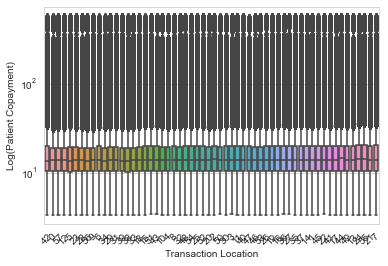

In [24]:
plot_order = \
    df_accepted[df_accepted.rejected == False] \
    .groupby("pharmacy") \
    .mean() \
    .sort_values("patient_pay") \
    .index

sns.boxplot(
    x = "pharmacy",
    y = "patient_pay",
    data = df_accepted[df_accepted.rejected == False],
    order = plot_order
).set_yscale("log")
plt.xlabel("Transaction Location")
plt.ylabel("Log(Patient Copayment)")
plt.xticks(rotation = 45)


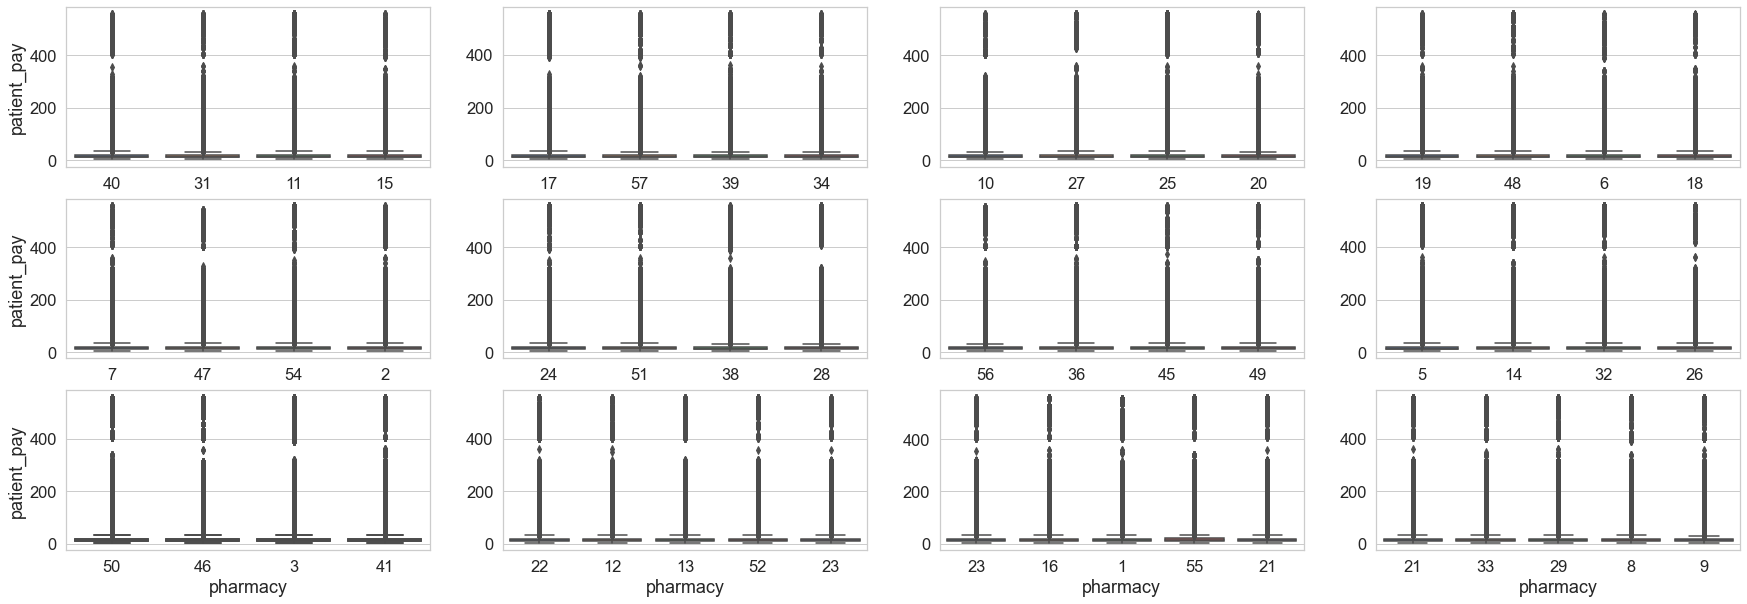

In [25]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})
cols = 4
rows = int(len(pharmacy_vars)/(cols*cols))
fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
all_axes = rows*cols
xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 4]
ylabel_index = [k for k in range(all_axes) if k  % 4 == 0]

i = 0
for k in range(all_axes):
  ax = axes.flat[k]
  if k >= all_axes-3:
    data = df_accepted.loc[(df_accepted[col_var] == pharmacy_vars[i]) | (df_accepted[col_var] == pharmacy_vars[i+1]) | (df_accepted[col_var] == pharmacy_vars[i+2]) | (df_accepted[col_var] == pharmacy_vars[i+3]) | (df_accepted[col_var] == pharmacy_vars[i+4]) ]
  else:
    data = df_accepted.loc[(df_accepted[col_var] == pharmacy_vars[i]) | (df_accepted[col_var] == pharmacy_vars[i+1]) | (df_accepted[col_var] == pharmacy_vars[i+2]) | (df_accepted[col_var] == pharmacy_vars[i+3])]

  if k in ylabel_index:
    sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None)
  if k in xlabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(ylabel=None)
  if k in xlabel_index and k in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax)
  if k not in xlabel_index and k not in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None, ylabel=None)
  i += cols

Copayments are consistent across pharmacy locations.

## Copayments by Insurance Plan

Before examining how copayments vary across insurance plans, we first need to get a sense of how many different insurance plans and subcategories there are. 

<AxesSubplot:xlabel='bin', ylabel='count'>

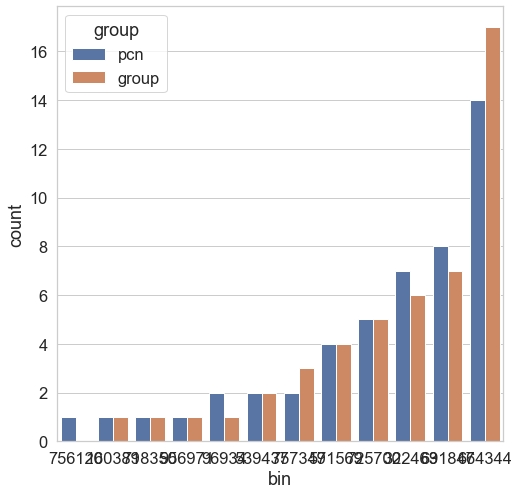

In [26]:
plot_data = \
    df_accepted[df_accepted.rejected == False] \
    .groupby("bin")[["pcn", "group"]] \
    .nunique() \
    .melt(
        value_vars = ["pcn", "group"], 
        var_name = "group", 
        value_name = "count",
        ignore_index = False
    ) \
    .reset_index()

plot_order = \
    plot_data \
    .groupby("bin") \
    .mean() \
    .sort_values("count") \
    .index

sns.barplot(
    x = "bin",
    y = "count",
    hue = "group",
    dodge = True,
    data = plot_data,
    order = plot_order
)

There are 12 total insurance plans and the smallest number of insurance options for any insurance plan is one. For example, plan 956971 offers one `pcn` and one `group`. On the other hand, 096934 offers two different `pcn`s with two different `group`s each for a total of four options. 

In [27]:
df_accepted.isna().sum() 

tx_date              0
pharmacy             0
diagnosis            0
drug                 0
bin                  0
pcn            2657374
group          2895854
rejected             0
patient_pay          0
dtype: int64

Since many values of pcn and group are missing they will be filled with unknown for now.

In [28]:
col_var = 'pcn'
df_accepted_total[col_var] = df_accepted_total[col_var].fillna('Unknown')
df_accepted[col_var] = df_accepted[col_var].fillna('Unknown')

col_var = 'group'
df_accepted_total[col_var] = df_accepted_total[col_var].fillna('Unknown')
df_accepted[col_var] = df_accepted[col_var].fillna('Unknown')

Text(0, 0.5, 'Log(Patient Copayment)')

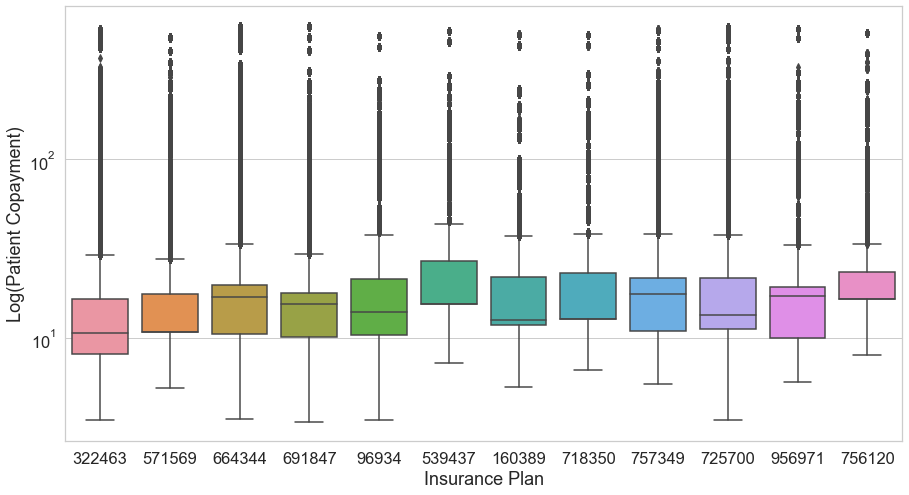

In [29]:
plot_order = \
    df_accepted[df_accepted.rejected == False] \
    .groupby("bin") \
    .mean() \
    .sort_values("patient_pay") \
    .index
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [15, 8]})
sns.boxplot(
    x = "bin",
    y = "patient_pay",
    data = df_accepted[df_accepted.rejected == False],
    order = plot_order
).set_yscale("log")
plt.xlabel("Insurance Plan")
plt.ylabel("Log(Patient Copayment)")

**Observations**
1. The bins looks pretty similar except for bin 664344 that has a higher number of patients with copayment above $400

In [68]:
col_var = 'pcn'
pcn_vars = df_accepted[col_var].unique()

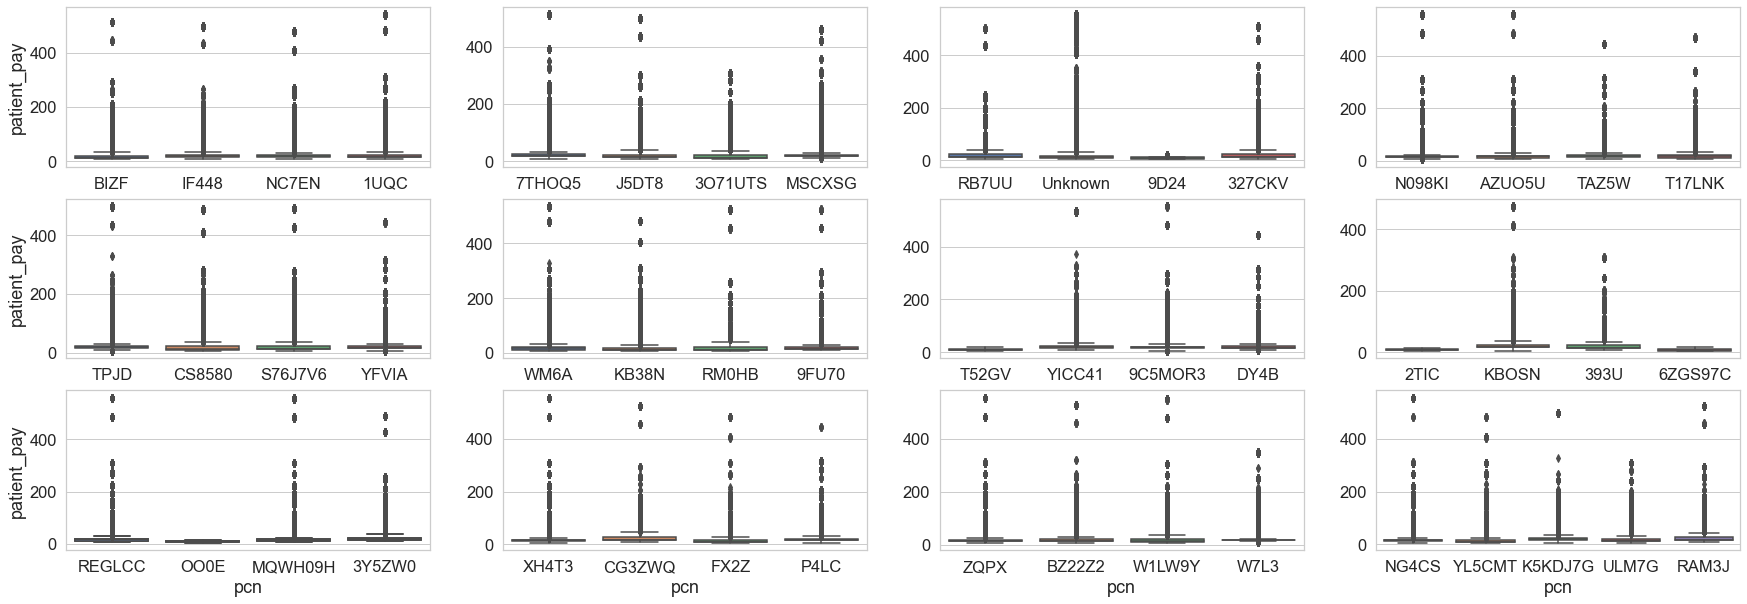

In [69]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})
cols = 4
rows = int(len(pcn_vars)/(cols*cols))
fig, axes = plt.subplots(rows, cols, figsize=(30, 10))

all_axes = rows*cols
xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 4]
ylabel_index = [k for k in range(all_axes) if k  % 4 == 0]

i = 0
for k in range(all_axes):
  ax = axes.flat[k]
  if k==all_axes-1:
    data = df_accepted.loc[(df_accepted[col_var] == pcn_vars[i]) | (df_accepted[col_var] == pcn_vars[i+1]) | (df_accepted[col_var] == pcn_vars[i+2]) | (df_accepted[col_var] == pcn_vars[i+3]) | (df_accepted[col_var] == pcn_vars[i+4]) ]
  else:
    data = df_accepted.loc[(df_accepted[col_var] == pcn_vars[i]) | (df_accepted[col_var] == pcn_vars[i+1]) | (df_accepted[col_var] == pcn_vars[i+2]) | (df_accepted[col_var] == pcn_vars[i+3])]
  if k in ylabel_index:
    sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None)
  if k in xlabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(ylabel=None)
  if k in xlabel_index and k in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax)
  if k not in xlabel_index and k not in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None, ylabel=None)
  i += cols

**Observations**
1. The pcn corresponding to T52GV, OO0E, 6ZGS97C, 9D24 and 2TIC seems to have a patient's pay value of close to 0.
2. Most of the other pcn class have  few outliers except for 3O71UTS, 393U, ULM7G, W7L3
3. The unknown class looks dense and may further be grouped by group or bin number

In [32]:
col_var = 'group'
group_vars = df_accepted[col_var].unique()

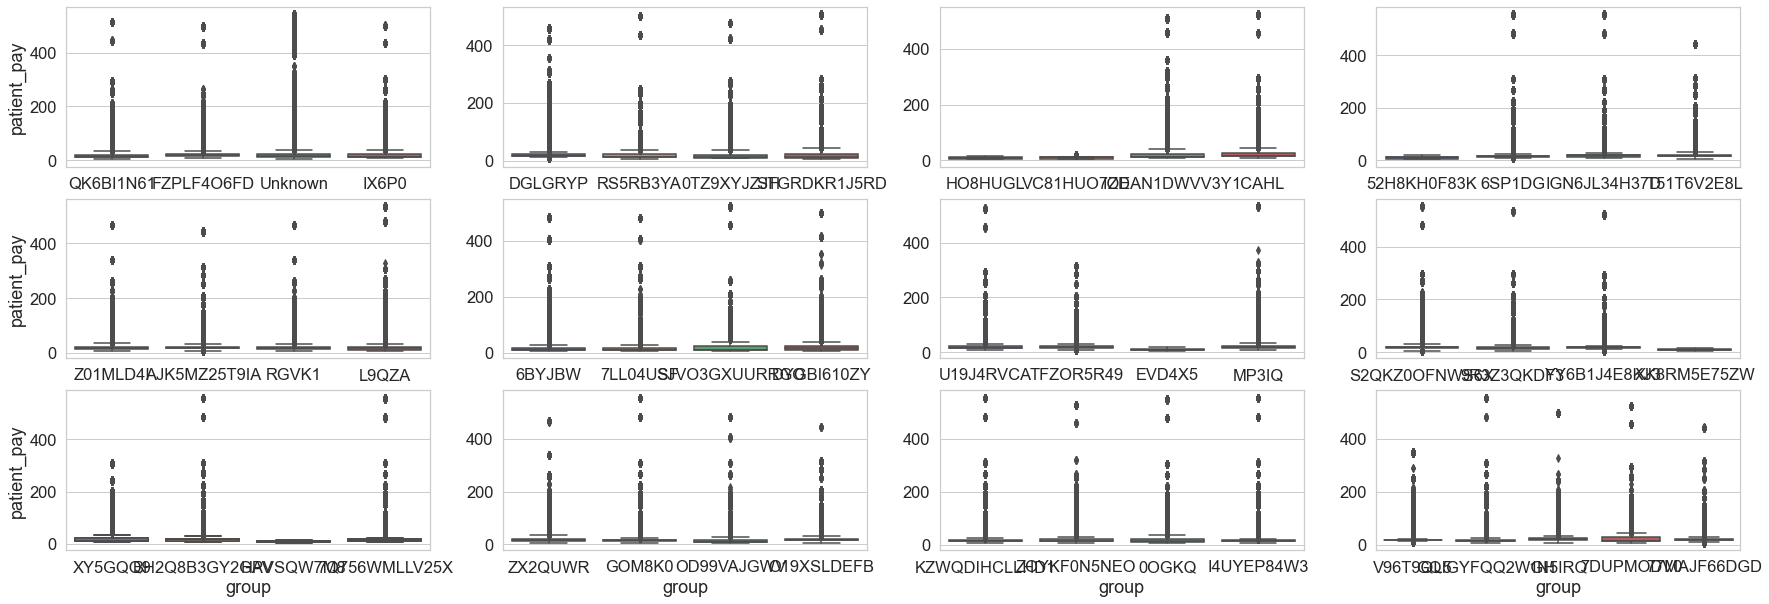

In [33]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})
cols = 4
rows = int(len(group_vars)/(cols*cols))
fig, axes = plt.subplots(rows, cols, figsize=(30, 10))

all_axes = rows*cols
xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 4]
ylabel_index = [k for k in range(all_axes) if k  % 4 == 0]

i = 0
for k in range(all_axes):
  ax = axes.flat[k]
  if k==all_axes-1:
    data = df_accepted.loc[(df_accepted[col_var] == group_vars[i]) | (df_accepted[col_var] == group_vars[i+1]) | (df_accepted[col_var] == group_vars[i+2]) | (df_accepted[col_var] == group_vars[i+3]) | (df_accepted[col_var] == group_vars[i+4]) ]
  else:
    data = df_accepted.loc[(df_accepted[col_var] == group_vars[i]) | (df_accepted[col_var] == group_vars[i+1]) | (df_accepted[col_var] == group_vars[i+2]) | (df_accepted[col_var] == group_vars[i+3])]
  if k in ylabel_index:
    sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None)
  if k in xlabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(ylabel=None)
  if k in xlabel_index and k in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax)
  if k not in xlabel_index and k not in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None, ylabel=None)
  i += cols

**Observations**
1.  The distributions for the insurance group vary by group. HO8HU, VC81H, HPVSQ, XK8RM, and EVD4X seem to have the lowest copayments.
2. The 'group' feature might be one of the most predictive feature for patient's pay
3. Some of the groups have almost zero copayments such as `52H8K, STGRD, EVD4X, HPVSQ, XK8RM, VC81H`

**How does PCN vary by group?**

In [67]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})

In [38]:
def plot_insurance(data,col_var,vars):
  sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})
  cols = 4
  rows = int(np.ceil(len(vars)/(cols*cols)))
  fig, axes = plt.subplots(rows, cols, figsize=(30, 20))

  all_axes = rows*cols
  xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 5]
  i = 0
  for axis in range(all_axes):
    ax = axes.flat[axis]
    data_new = data.loc[(data[col_var] == vars[i]) | (data[col_var] == vars[i+1]) | (data[col_var] == vars[i+2]) | (data[col_var] == vars[i+3]) | (data[col_var] == vars[i+4]) ]
    sns.countplot(x=col_var, hue="group", data=data_new,ax=ax)
    i+=4

IndexError: index 49 is out of bounds for axis 0 with size 49

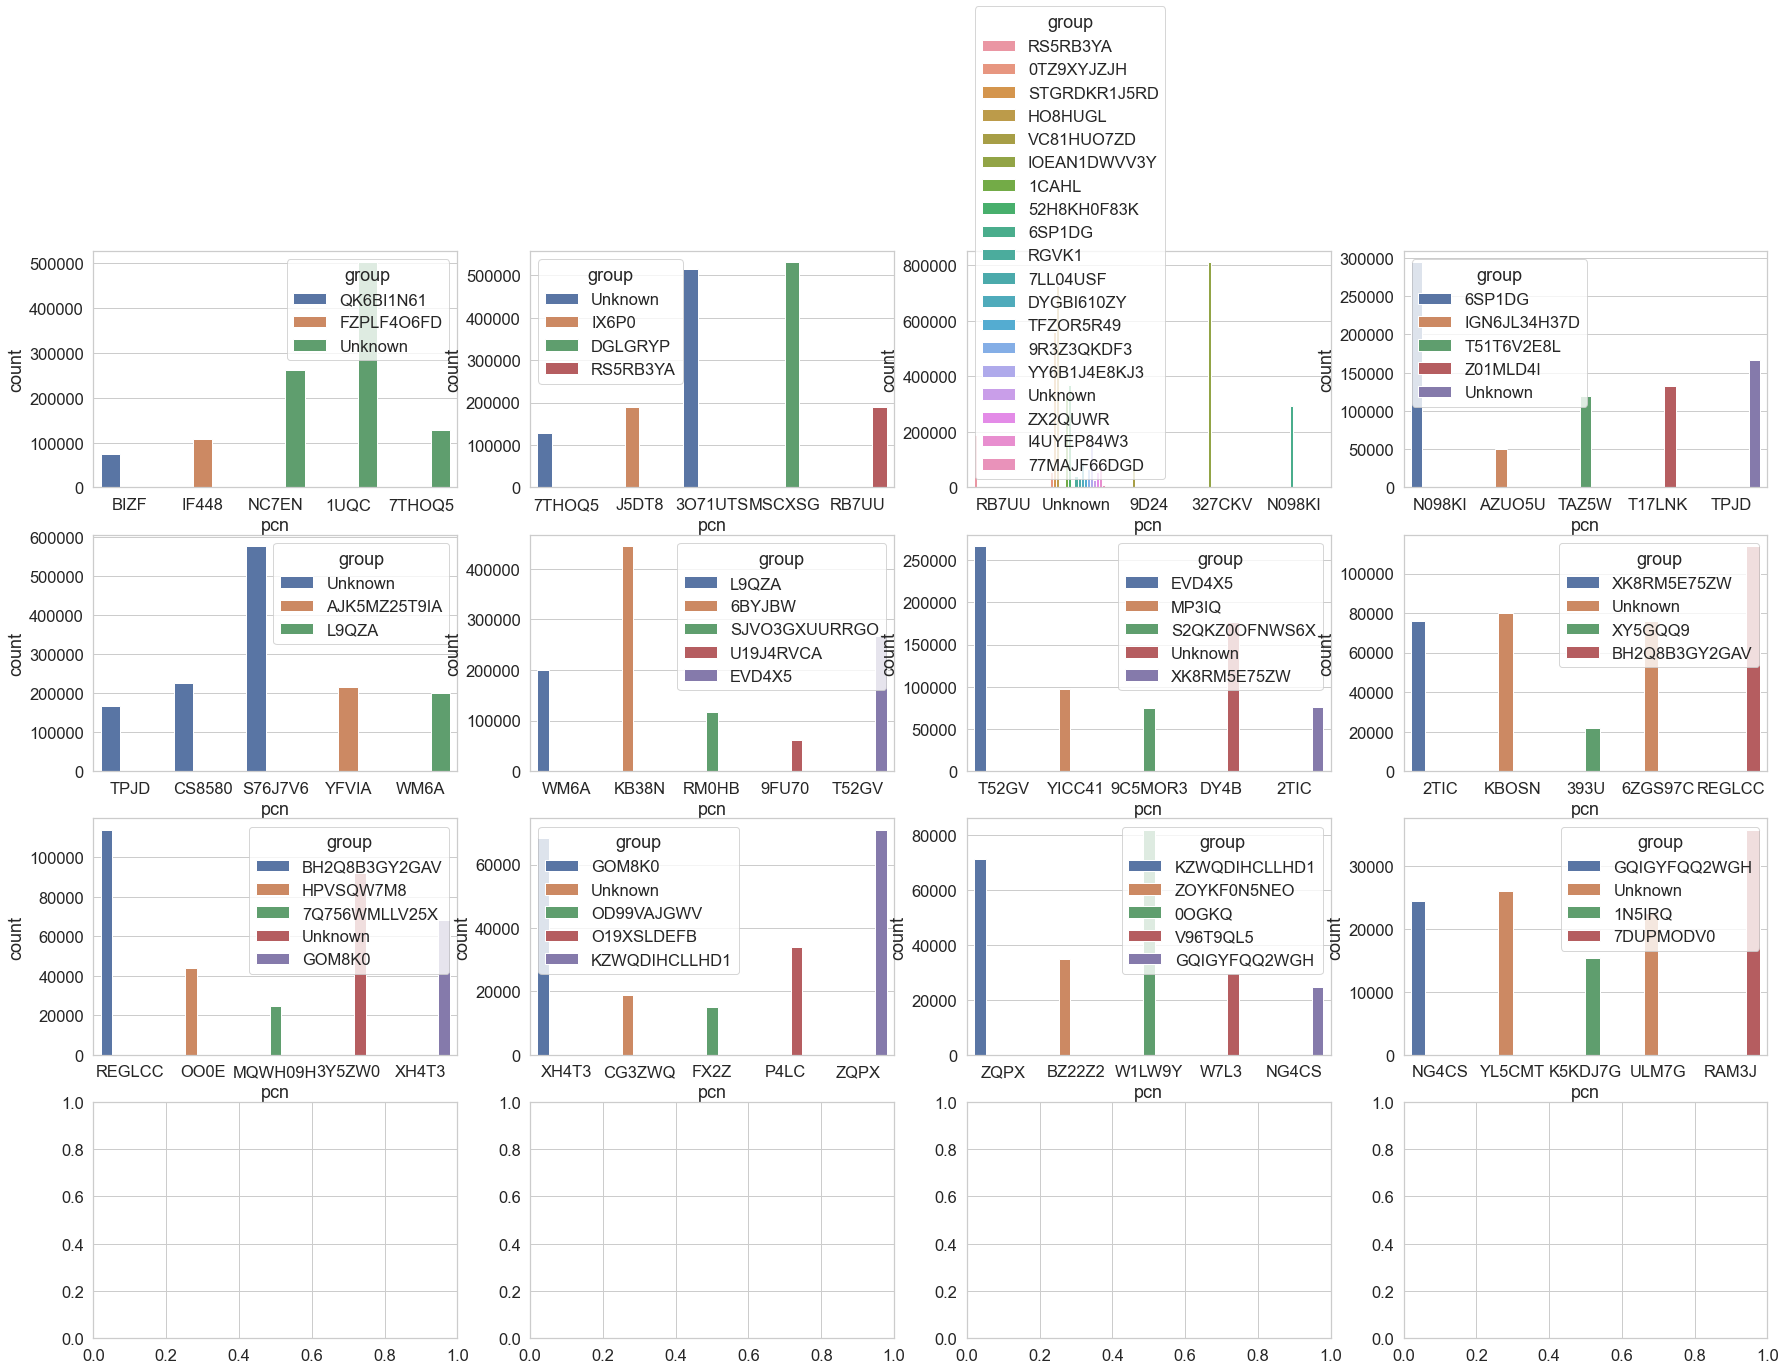

In [37]:
col_var = 'pcn'
vars = df_accepted[col_var].unique()
plot_insurance(df_accepted,col_var,vars)

**Observations**
1.  Each pcn only has one group that corresponds to it except the missing pcn's
2. This shows that each `group` is unique to each `pcn`. Additionally, there doesn't seem to be multiple `group`s per `pcn`. 
3. The 'group' feature may not be needed if we use it to impute the missing data from pcn.

**How does pcn vary by bin?**

IndexError: index 15 is out of bounds for axis 0 with size 15

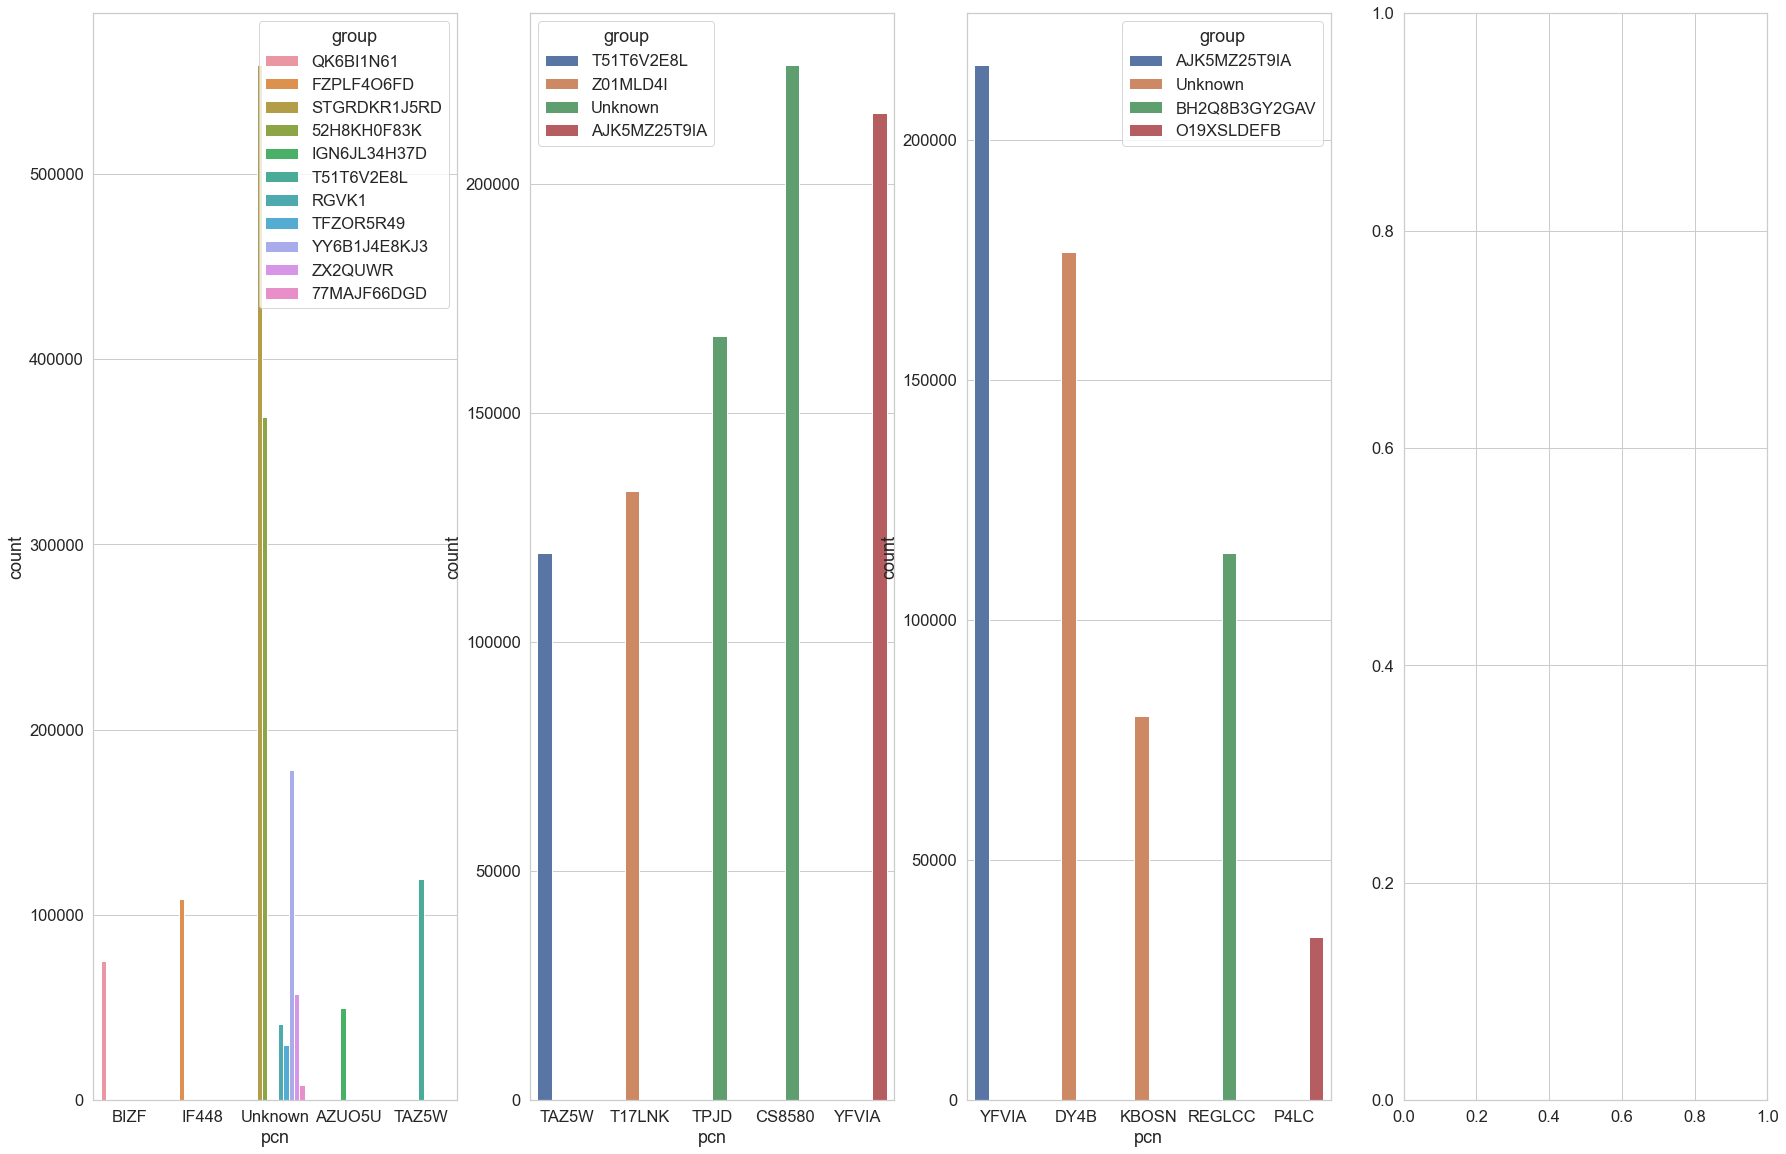

In [70]:
bin_var = df_accepted.bin.unique()
bin_1 = df_accepted.loc[(df_accepted['bin'] == bin_var[0])]
col_var='pcn'
vars = bin_1[col_var].unique()
plot_insurance(bin_1,col_var,vars)

<AxesSubplot:xlabel='pcn', ylabel='count'>

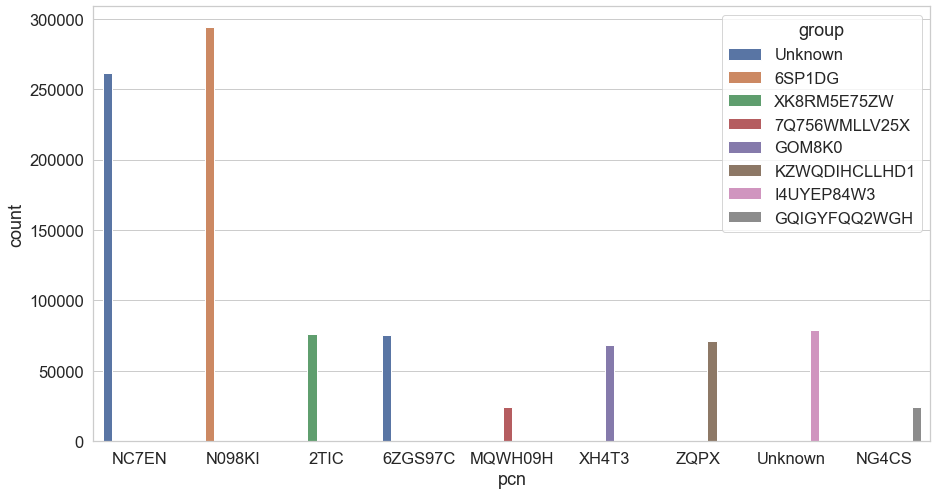

In [82]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [15, 8]})
bin_var = df_accepted.bin.unique()
bin_2 = df_accepted.loc[(df_accepted['bin'] == bin_var[1])]
sns.countplot(x=col_var, hue="group", data=bin_2)

<AxesSubplot:xlabel='pcn', ylabel='count'>

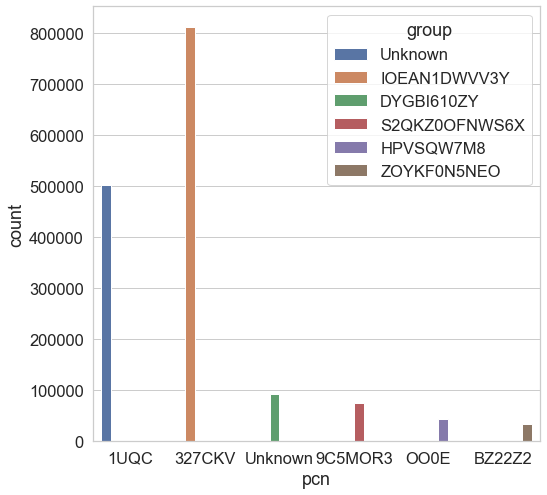

In [72]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 8]})
bin_var = df_accepted.bin.unique()
bin_3 = df_accepted.loc[(df_accepted['bin'] == bin_var[2])]
sns.countplot(x=col_var, hue="group", data=bin_3)

<AxesSubplot:xlabel='pcn', ylabel='count'>

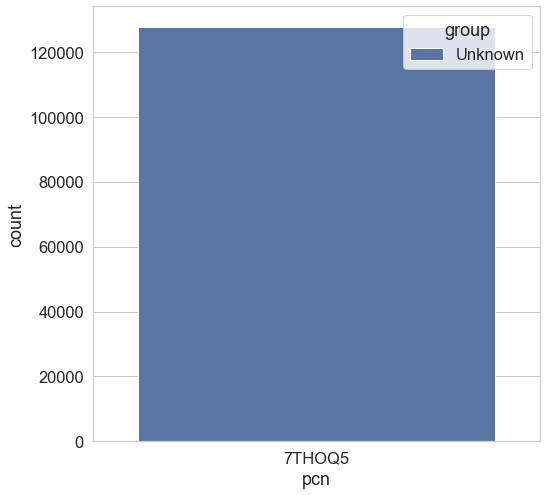

In [73]:
bin_var = df_accepted.bin.unique()
bin_4 = df_accepted.loc[(df_accepted['bin'] == bin_var[3])]
sns.countplot(x=col_var, hue="group", data=bin_4)

<AxesSubplot:xlabel='pcn', ylabel='count'>

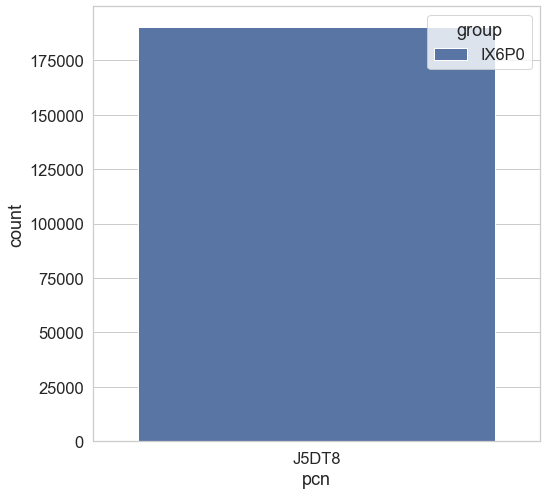

In [74]:
bin_var = df_accepted.bin.unique()
bin_5 = df_accepted.loc[(df_accepted['bin'] == bin_var[4])]
sns.countplot(x=col_var, hue="group", data=bin_5)

<AxesSubplot:xlabel='pcn', ylabel='count'>

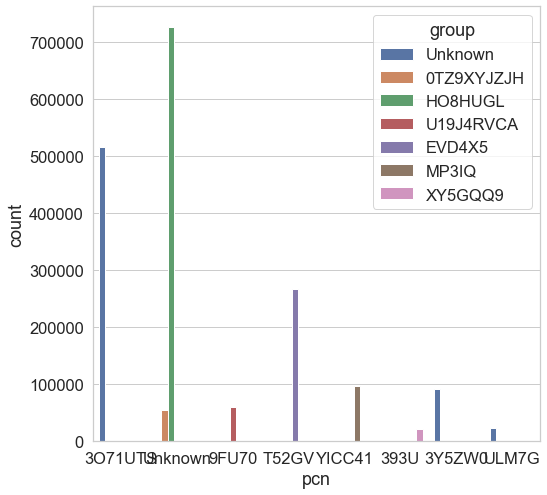

In [75]:
bin_var = df_accepted.bin.unique()
bin_6 = df_accepted.loc[(df_accepted['bin'] == bin_var[5])]
sns.countplot(x=col_var, hue="group", data=bin_6)

<AxesSubplot:xlabel='pcn', ylabel='count'>

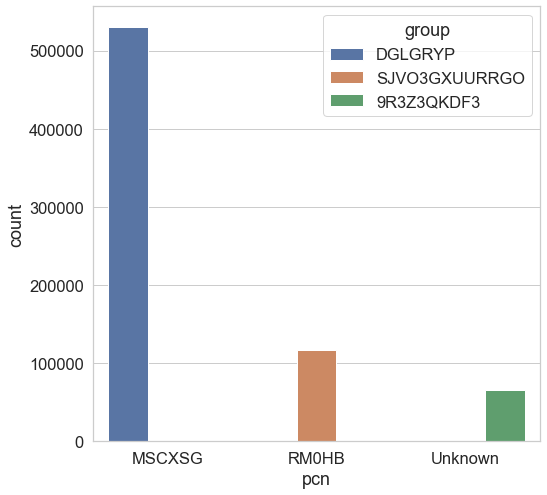

In [76]:
bin_var = df_accepted.bin.unique()
bin_7 = df_accepted.loc[(df_accepted['bin'] == bin_var[6])]
sns.countplot(x=col_var, hue="group", data=bin_7)

<AxesSubplot:xlabel='pcn', ylabel='count'>

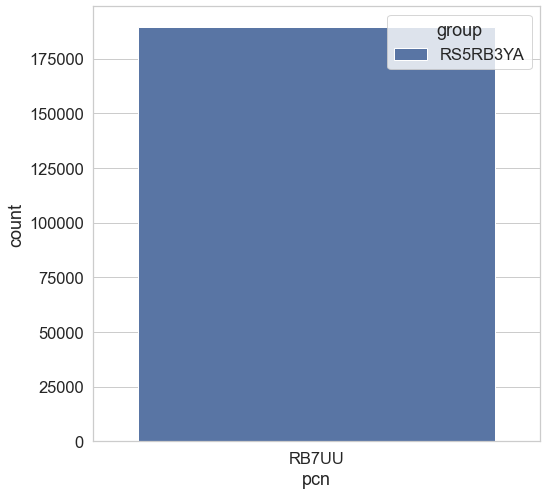

In [81]:
bin_var = df_accepted.bin.unique()
bin_8 = df_accepted.loc[(df_accepted['bin'] == bin_var[7])]
sns.countplot(x=col_var, hue="group", data=bin_8)

<AxesSubplot:xlabel='pcn', ylabel='count'>

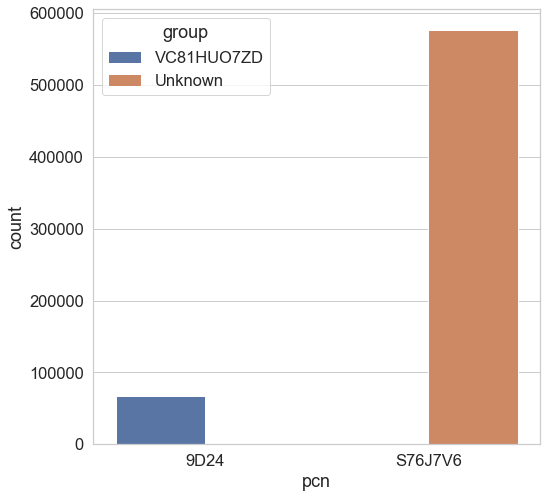

In [77]:
bin_var = df_accepted.bin.unique()
bin_9 = df_accepted.loc[(df_accepted['bin'] == bin_var[8])]
sns.countplot(x=col_var, hue="group", data=bin_9)

<AxesSubplot:xlabel='pcn', ylabel='count'>

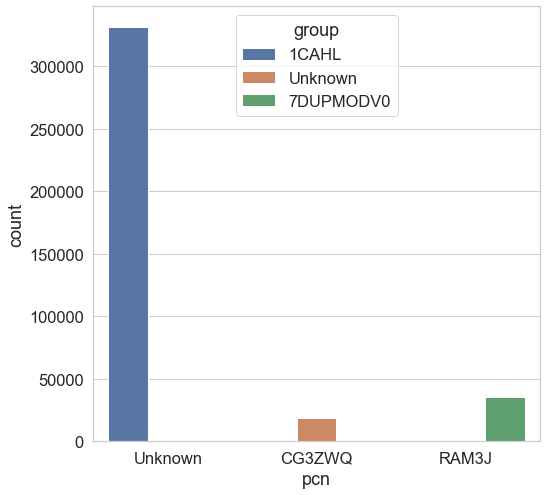

In [80]:
bin_var = df_accepted.bin.unique()
bin_10 = df_accepted.loc[(df_accepted['bin'] == bin_var[9])]
sns.countplot(x=col_var, hue="group", data=bin_10)

<AxesSubplot:xlabel='pcn', ylabel='count'>

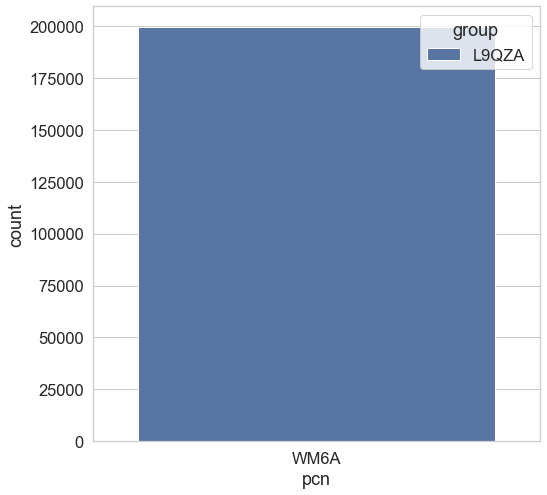

In [78]:
bin_var = df_accepted.bin.unique()
bin_11 = df_accepted.loc[(df_accepted['bin'] == bin_var[10])]
sns.countplot(x=col_var, hue="group", data=bin_11)

<AxesSubplot:xlabel='pcn', ylabel='count'>

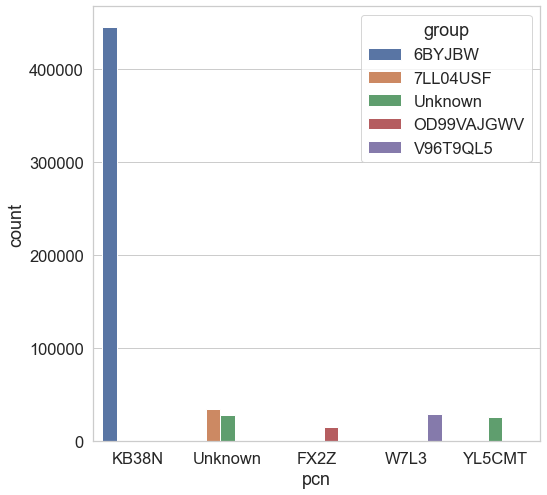

In [79]:
bin_var = df_accepted.bin.unique()
bin_12 = df_accepted.loc[(df_accepted['bin'] == bin_var[11])]
sns.countplot(x=col_var, hue="group", data=bin_12)

**How does copay vary by bin?**

There is a small amount of variance in patient copayments by insurance plan with the mean values ranging from about \$12 to \$16. 

Finally, let's examine how much variation in copayments there is within insurance plans (across `pcn`s and `group`s). 

There is also a good amount of variance in copayments by insurance plan subcategory. 

## Copayments by Diagnosis

Here we examine how copayments vary by diagnosis. As noted above, there are 133 diagnoses in the data. Each diagnosis starts with a letter and in total there are 25 different leading letters. 

Using these leading letters, we'll examine the variation in copayments across diagnosis group:

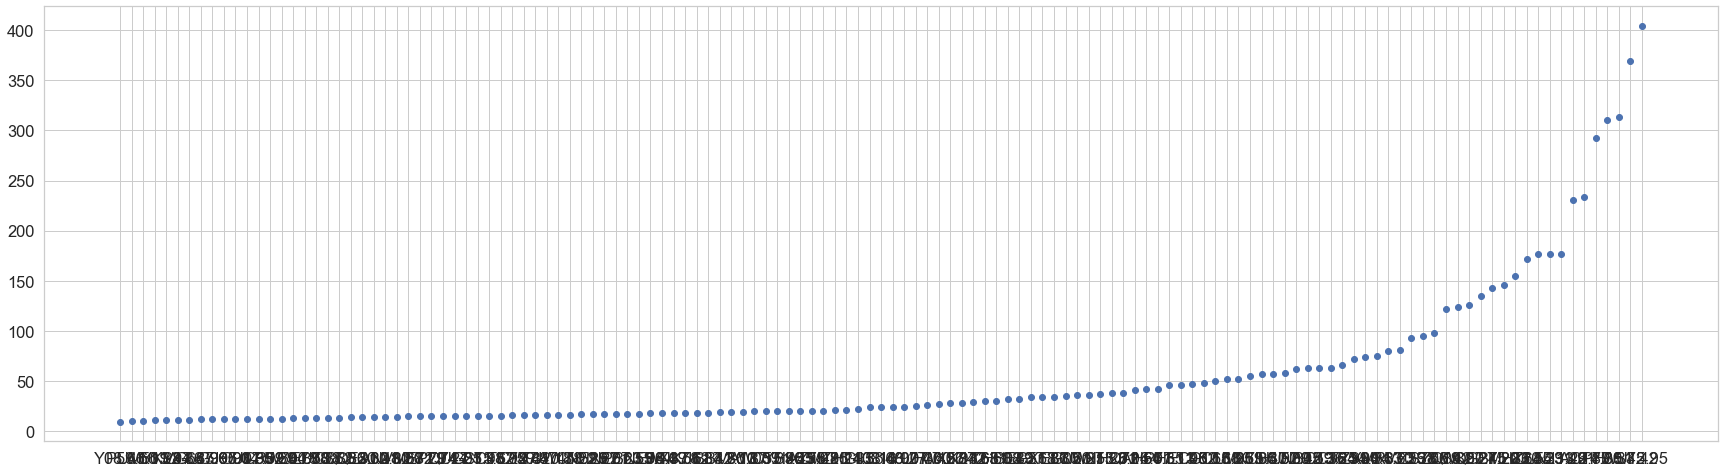

In [40]:
plot_data = \
    df_accepted \
    .groupby("diagnosis") \
    .aggregate({"patient_pay" : "mean"}) \
    .reset_index() \
    .sort_values("patient_pay")

plt.figure(figsize=(50, 8))
plt.scatter(
    x = "diagnosis",
    y = "patient_pay",
    data = plot_data
)

In [41]:
col_var = 'diagnosis'
diagnosis_vars = df_accepted[col_var].unique()

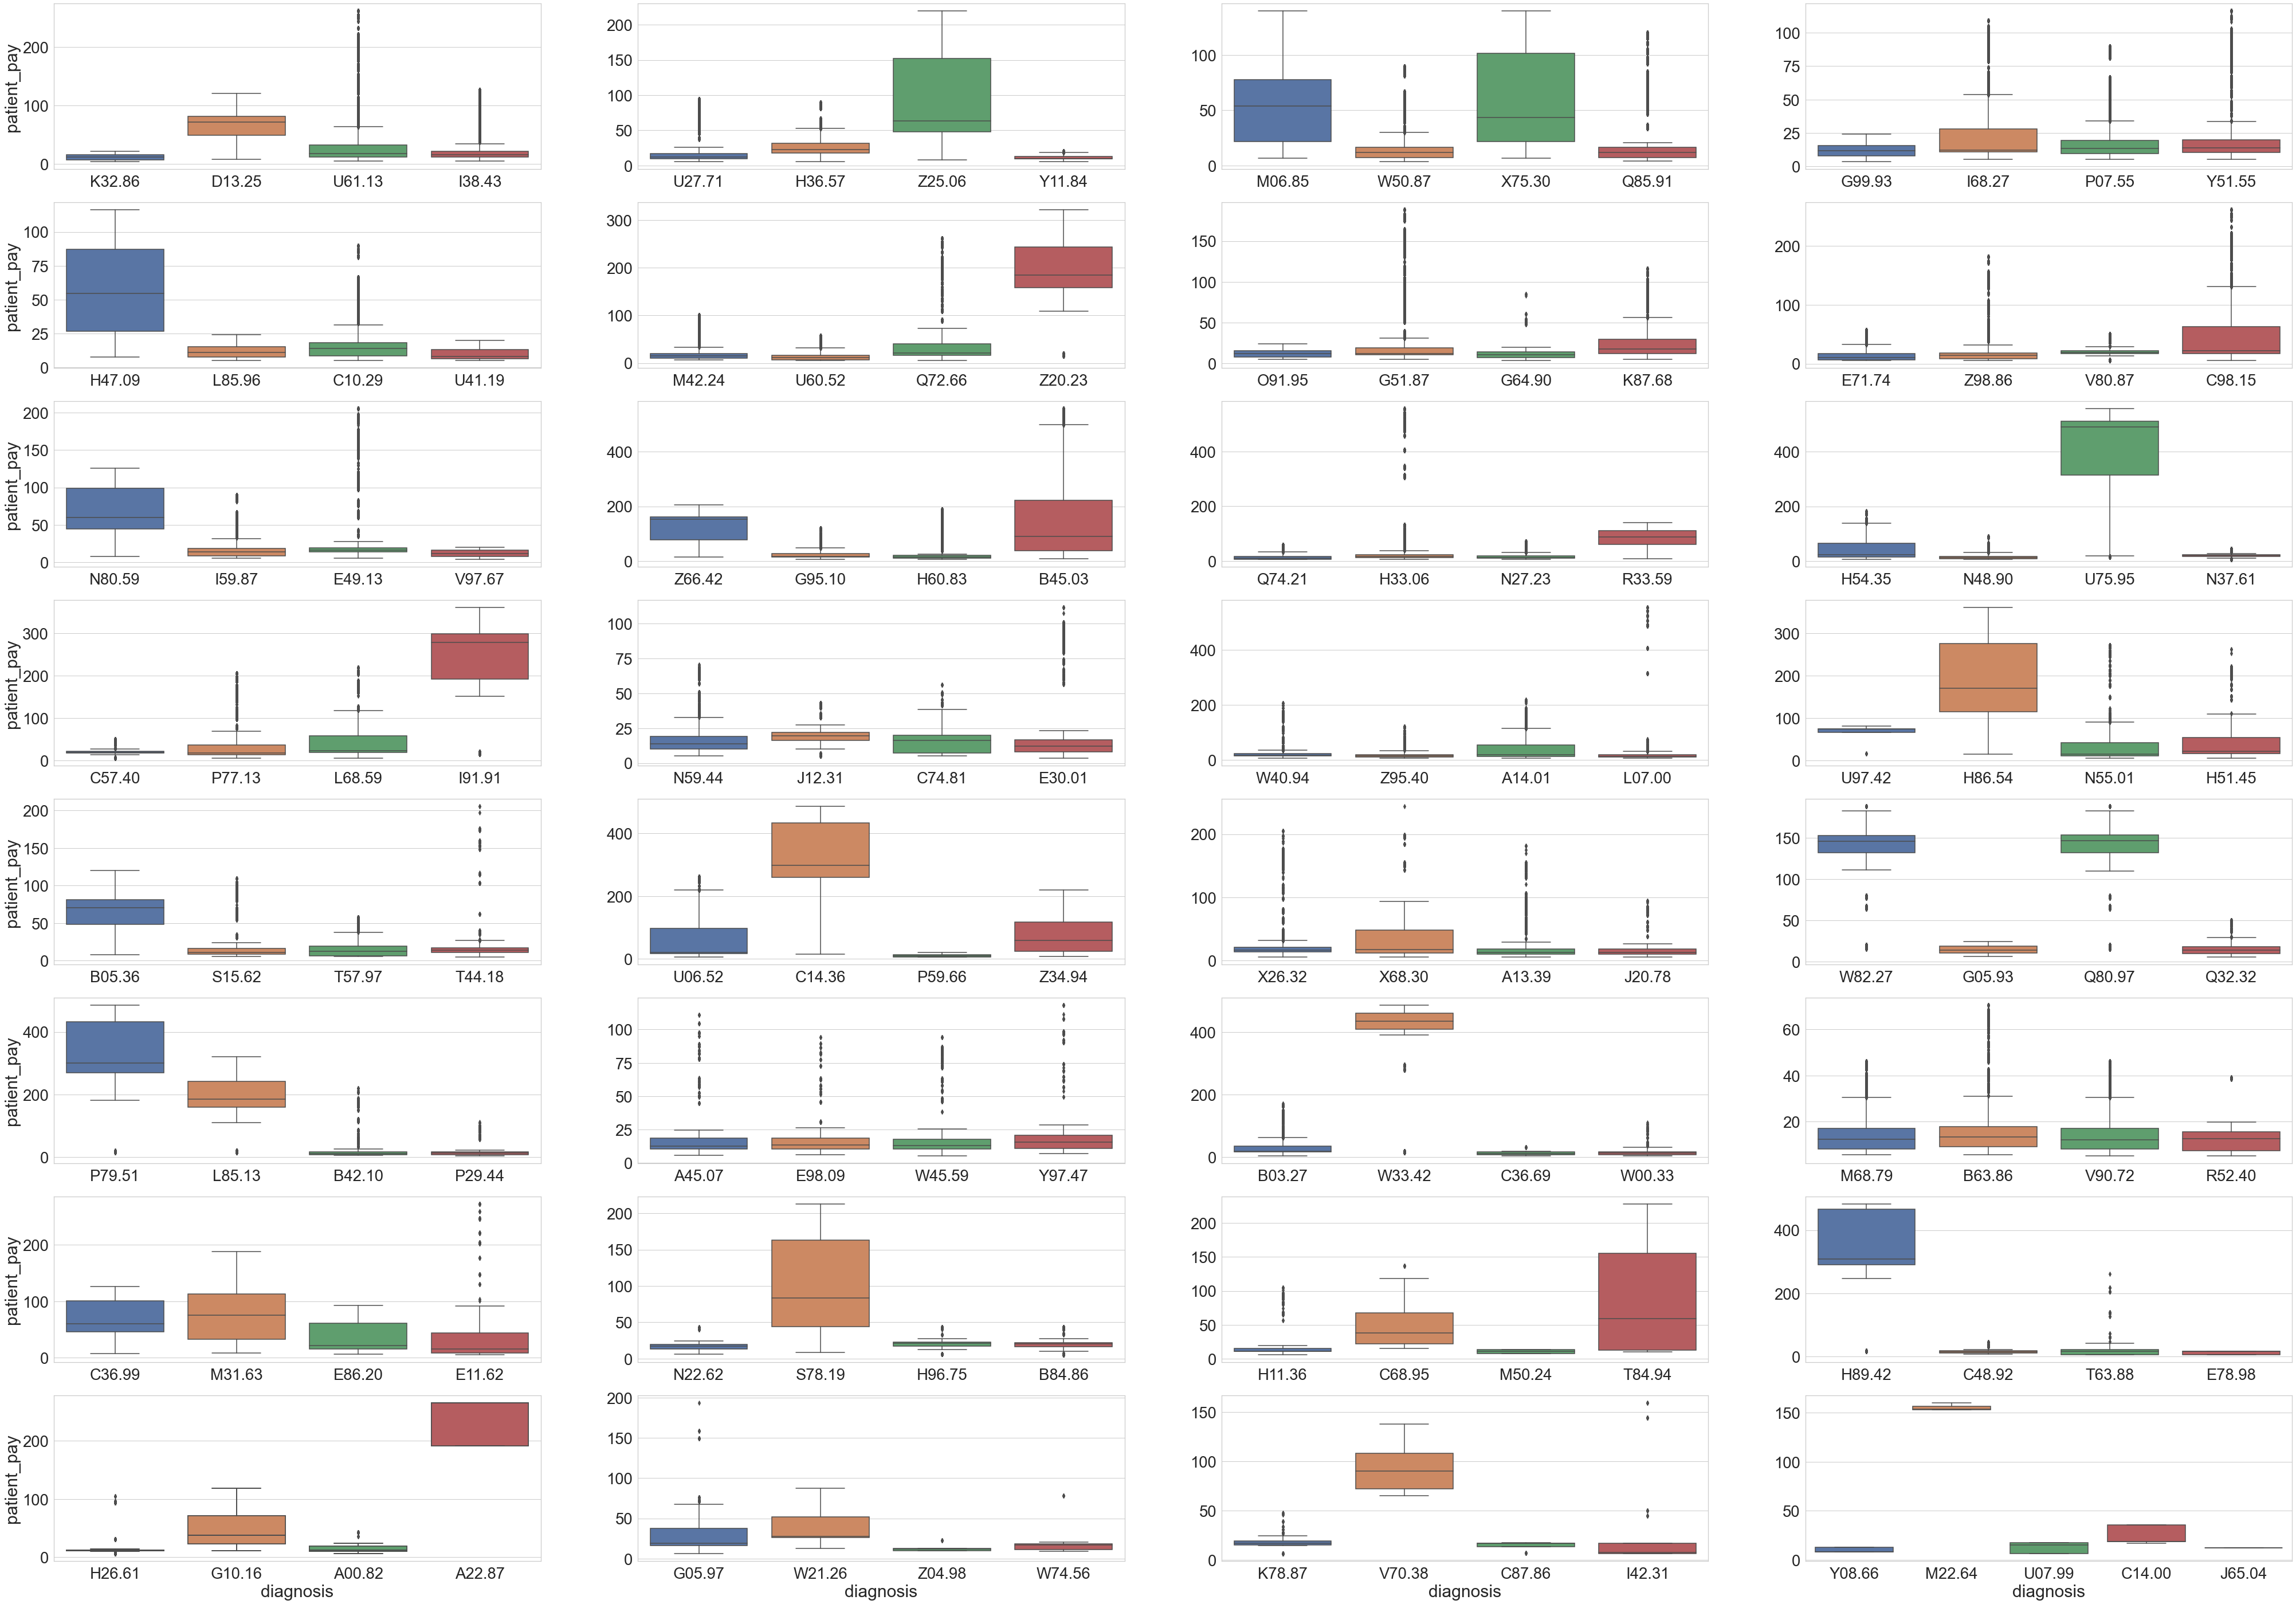

In [42]:
sns.set(style='whitegrid', palette="deep", font_scale=2.5, rc={"figure.figsize": [8, 8]})
cols = 4
rows = int(len(diagnosis_vars)/(cols*cols))
fig, axes = plt.subplots(rows, cols, figsize=(70, 50))
all_axes = rows*cols
xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 4]
ylabel_index = [k for k in range(all_axes) if k  % 4 == 0]

i = 0
for k in range(all_axes):
  ax = axes.flat[k]
  if k==all_axes-1:
    data = df_accepted.loc[(df_accepted[col_var] == diagnosis_vars[i]) | (df_accepted[col_var] == diagnosis_vars[i+1]) | (df_accepted[col_var] == diagnosis_vars[i+2]) | (df_accepted[col_var] == diagnosis_vars[i+3]) | (df_accepted[col_var] == diagnosis_vars[i+4]) ]
  else:
    data = df_accepted.loc[(df_accepted[col_var] ==diagnosis_vars[i]) | (df_accepted[col_var] == diagnosis_vars[i+1]) | (df_accepted[col_var] == diagnosis_vars[i+2]) | (df_accepted[col_var] == diagnosis_vars[i+3])]
  if k in ylabel_index:
    sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None)
  if k in xlabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(ylabel=None)
  if k in xlabel_index and k in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax)
  if k not in xlabel_index and k not in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None, ylabel=None)

  i += cols

**Observations**

1. A majority of the diagnosis have a patient's pay of less than $100
2. Diganosis such as H89.42, P79.51, W33.42
3. Some diagnosis have less than 100 data points, these diagnosis will be combined into a diagonsis of 'other' so that cross validation can be used.


## Copayments by Drug

In this section, we examine how copayments vary with the drug prescribed. There are 114 unique drugs in the data. 

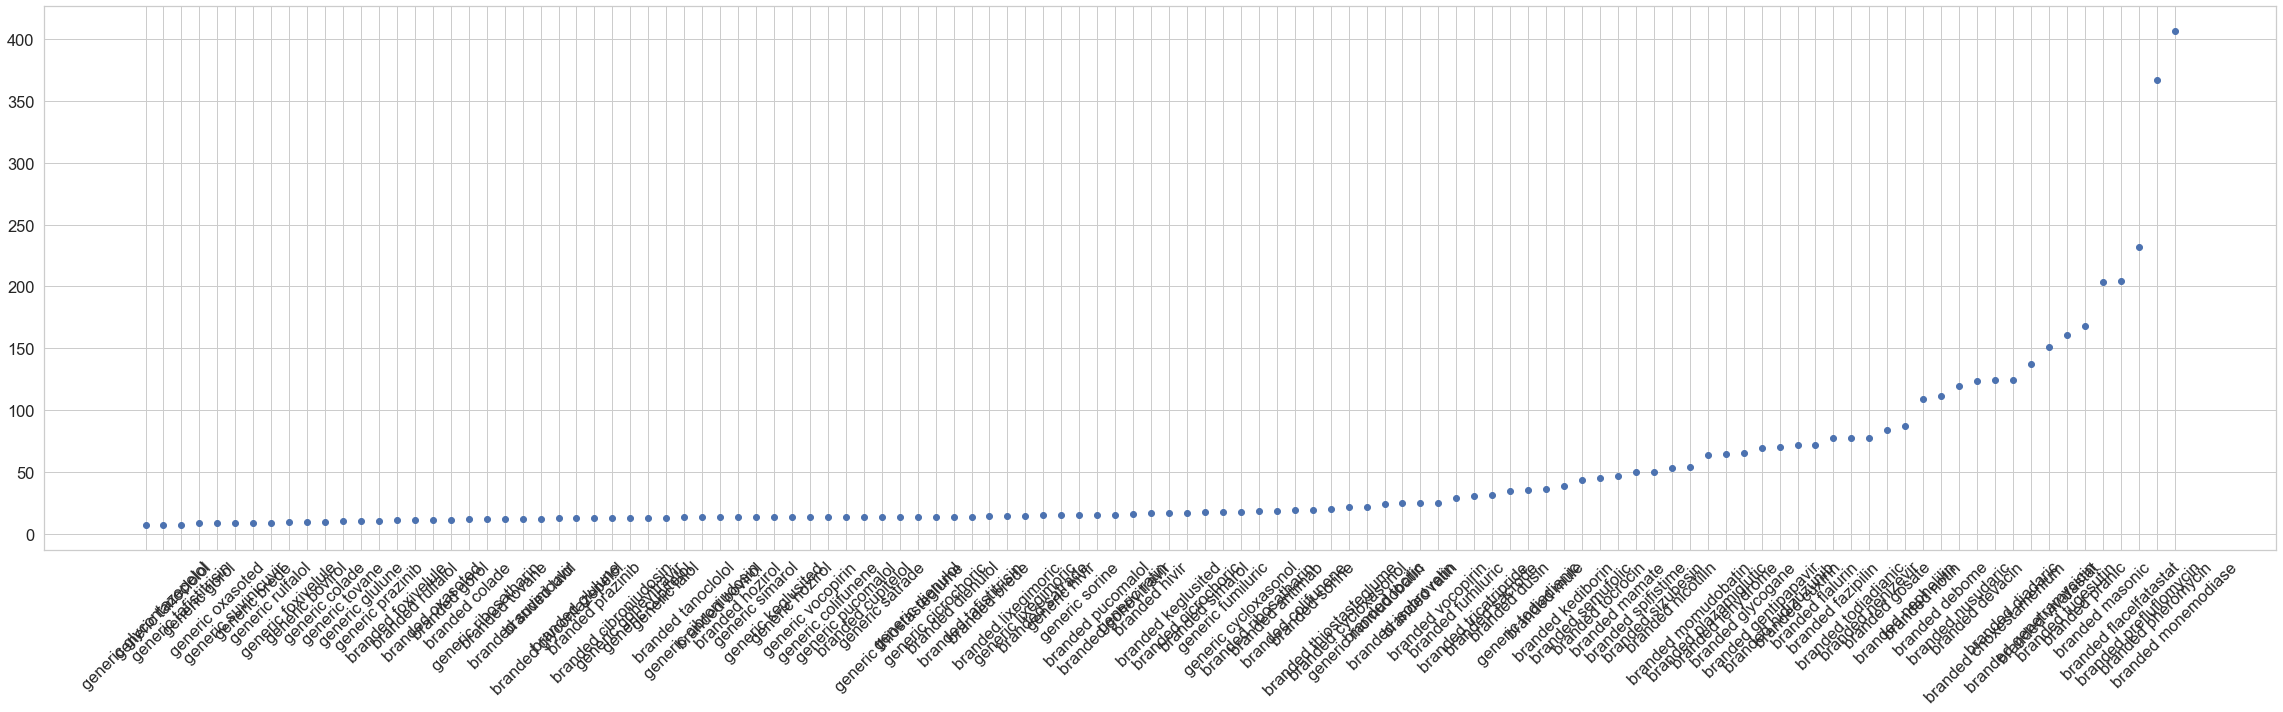

In [87]:
plot_data = \
    df_accepted \
    .groupby("drug") \
    .aggregate({"patient_pay" : "mean"}) \
    .reset_index() \
    .sort_values("patient_pay")

plt.figure(figsize=(40, 10))
plt.xticks(rotation=45)
plt.scatter(
    x = "drug",
    y = "patient_pay",
    data = plot_data
)


In [51]:
col_var = 'drug'
drug_vars = df_accepted[col_var].unique()

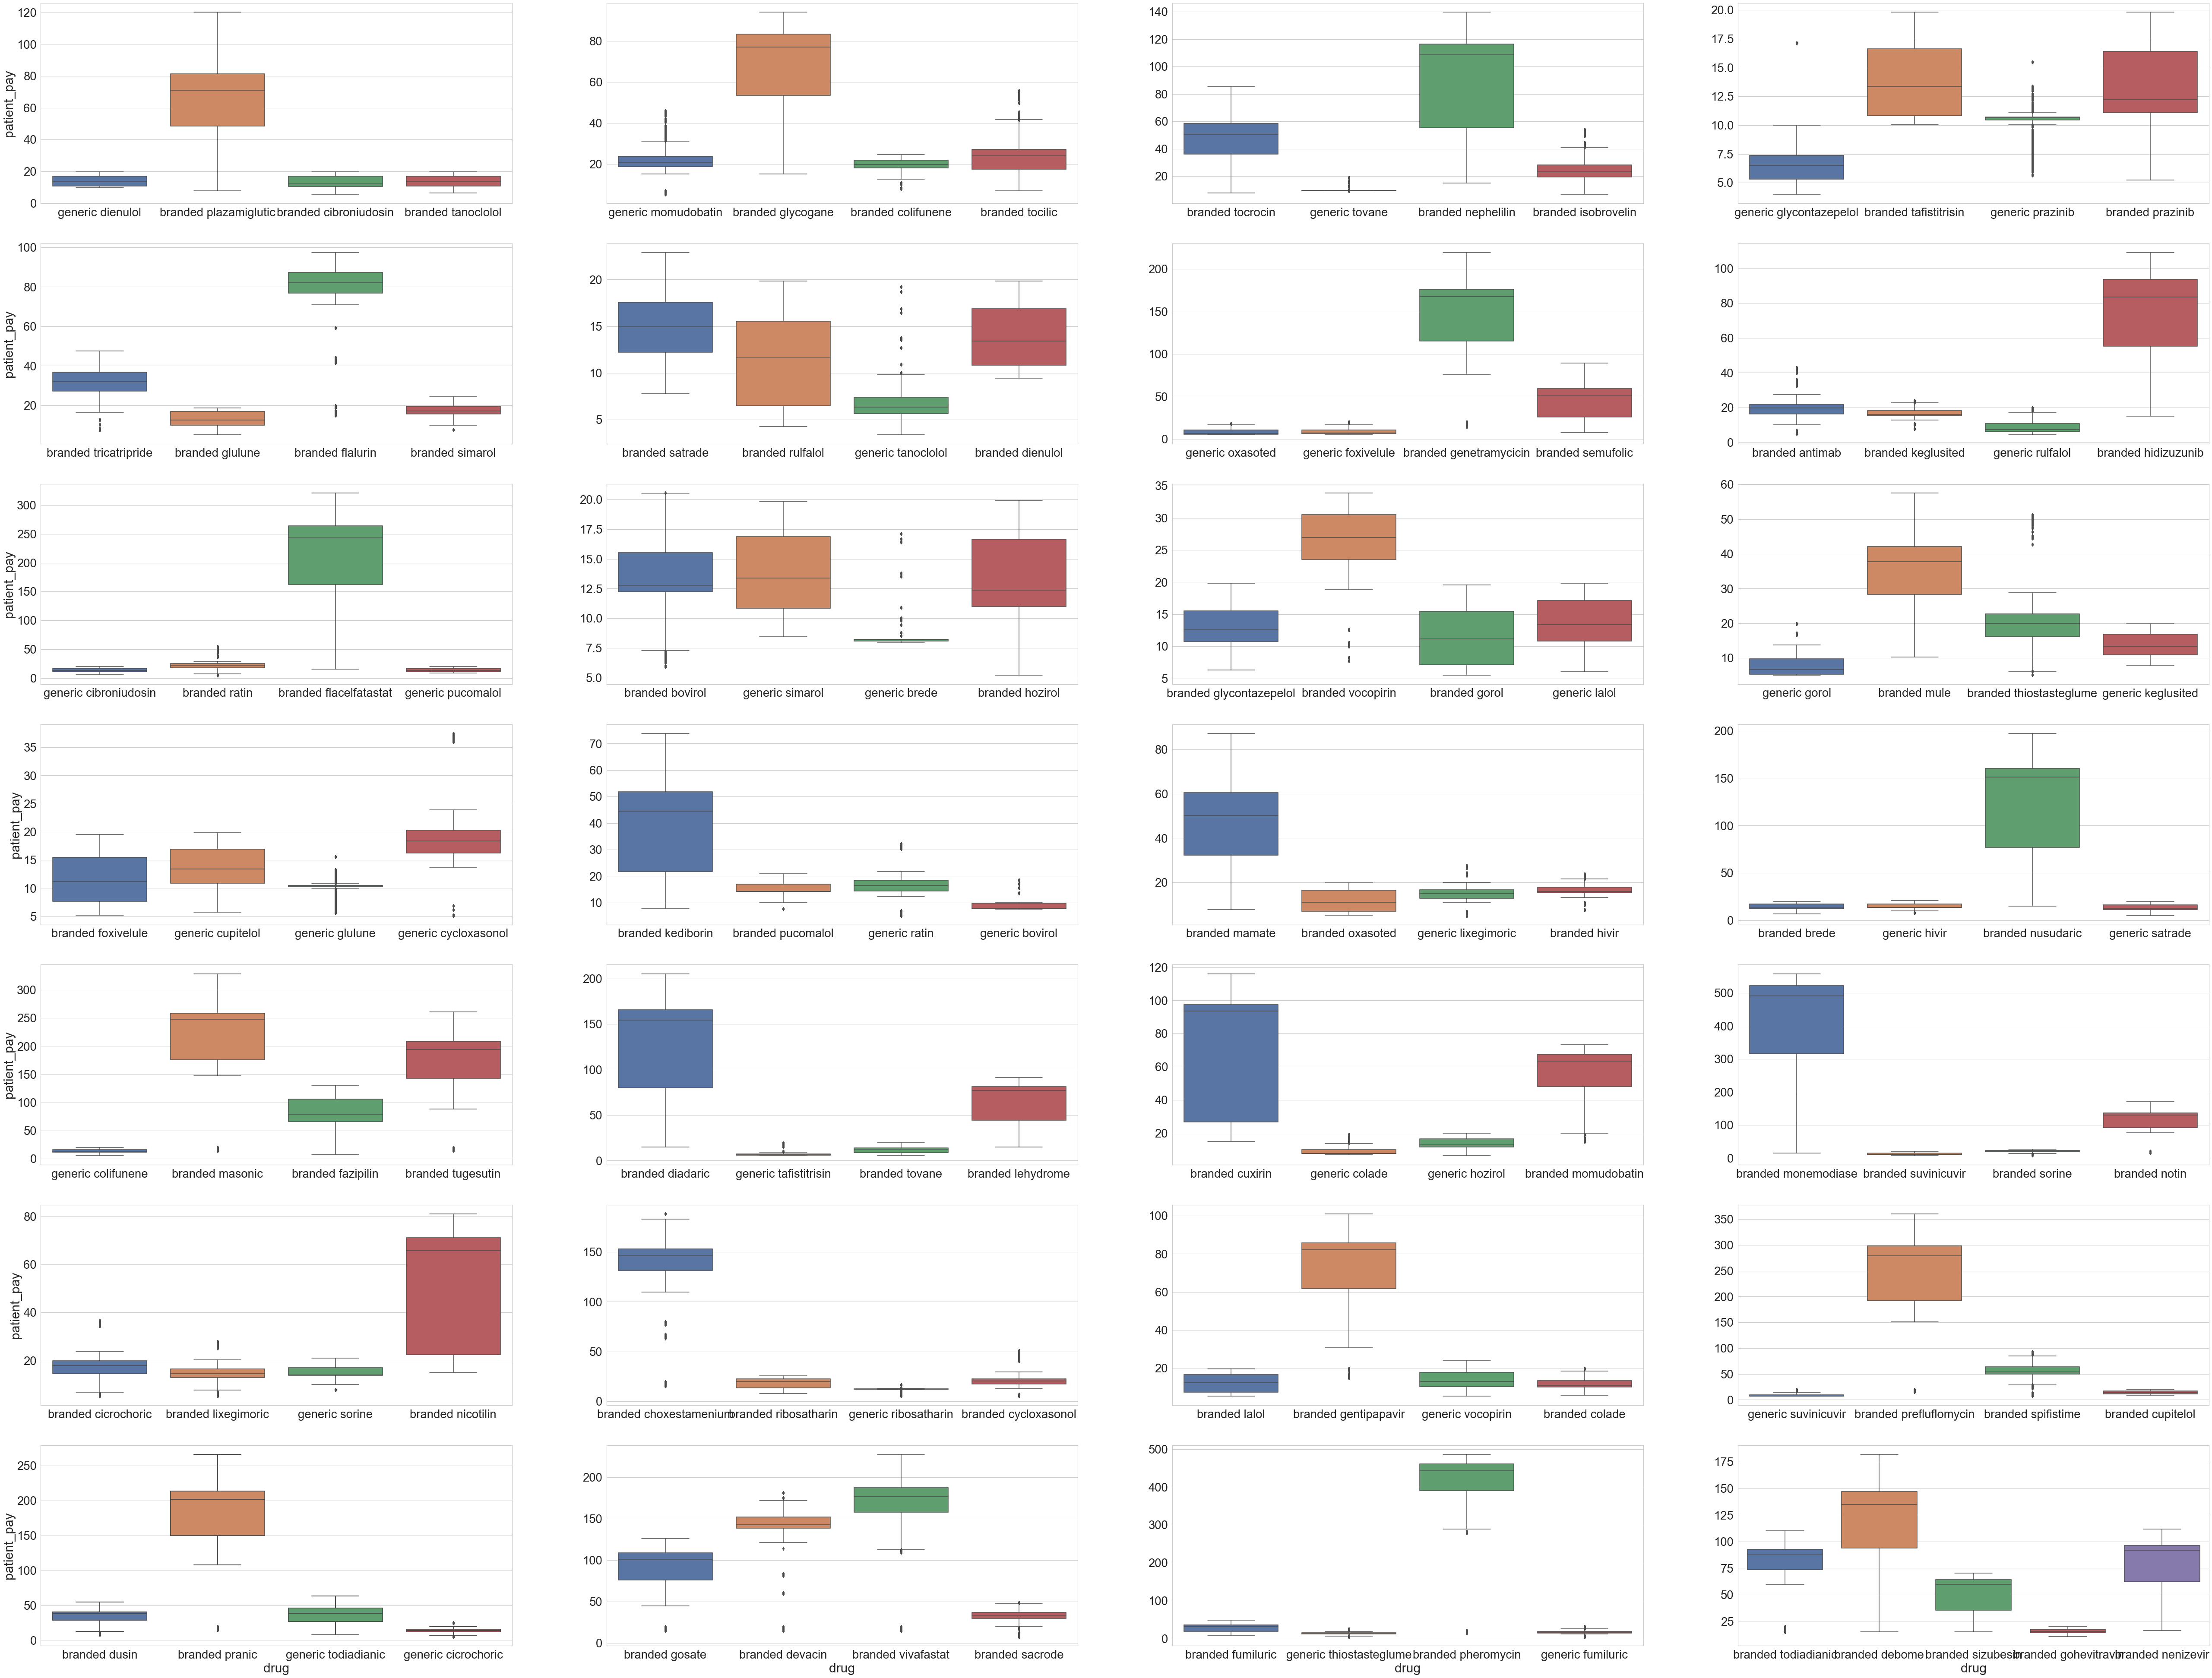

In [52]:
cols = 4
rows = int(len(drug_vars)/(cols*cols))
fig, axes = plt.subplots(rows, cols, figsize=(90, 70))
all_axes = rows*cols
xlabel_index = [k for k in range(all_axes) if k >=  all_axes - 4]
ylabel_index = [k for k in range(all_axes) if k  % 4 == 0]

i = 0
for k in range(all_axes):
  ax = axes.flat[k]
  if k==all_axes-1:
    data = df_accepted.loc[(df_accepted[col_var] == drug_vars[i]) | (df_accepted[col_var] == drug_vars[i+1]) | (df_accepted[col_var] == drug_vars[i+2]) | (df_accepted[col_var] == drug_vars[i+3]) | (df_accepted[col_var] == drug_vars[i+4]) ]
  else:
    data = df_accepted.loc[(df_accepted[col_var] ==drug_vars[i]) | (df_accepted[col_var] == drug_vars[i+1]) | (df_accepted[col_var] == drug_vars[i+2]) | (df_accepted[col_var] == drug_vars[i+3])]

  if k in ylabel_index:
    sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None)
  if k in xlabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(ylabel=None)
  if k in xlabel_index and k in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax)
  if k not in xlabel_index and k not in ylabel_index:
     sns.boxplot(x=col_var, y='patient_pay', data=data, ax=ax).set(xlabel=None, ylabel=None)
  i += cols

**Observations**
1.  The distributions for the `drug` is quite different for each class  with `b_diada, b_nusud, b_nephe, b_plaza, b_vivav, b_tuges, b_flace, b_choxe, b_fazip, b_todia, b_monem, b_prefi, b_phero, b_mason, b_prani, b_devac` having the highest copayments. A reasonable inference here is that these drugs are branded drugs
2. The `drug` feature might be one of the most predictive feature for patient's pay
3. Since in general branded drugs have a higher copay we will create a seperate column for branded and generic.

In [8]:
'drug_group'
col_var = 'drug'
df_accepted_total['drug_group'] = [val.split(' ')[0] for val in df_accepted_total[col_var]]
df_accepted_total['drug_type']= [val.split(' ')[1] for val in df_accepted_total[col_var]]

df_accepted['drug_group'] = [val.split(' ')[0] for val in df_accepted[col_var]]
df_accepted['drug_type']= [val.split(' ')[1] for val in df_accepted[col_var]]

<ipython-input-8-ce20c8b98ecc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_total['drug_group'] = [val.split(' ')[0] for val in df_accepted_total[col_var]]
<ipython-input-8-ce20c8b98ecc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_total['drug_type']= [val.split(' ')[1] for val in df_accepted_total[col_var]]


Text(0, 0.5, 'Log(Patient Copayment)')

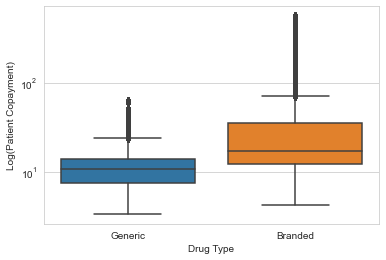

In [9]:
plot = sns.boxplot(
    x = "drug_group",
    y = "patient_pay",
    data = df_accepted
)
plot.set_xticklabels(["Generic", "Branded"])
plot.set_yscale("log")
plt.xlabel("Drug Type")
plt.ylabel("Log(Patient Copayment)")

Perhaps as expected, generic drugs are associated with lower copayments. Alternatively, we can compare the mean copayments for branded and generic drugs within each drug group.

<ipython-input-48-97cff21716c4>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(drug_alt = lambda x: x.drug.str.replace("generic|branded", "")) \
C:\Users\papri\anaconda3\lib\site-packages\seaborn\categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


Text(36.025000000000006, 0.5, 'Log(Patient Copayment)')

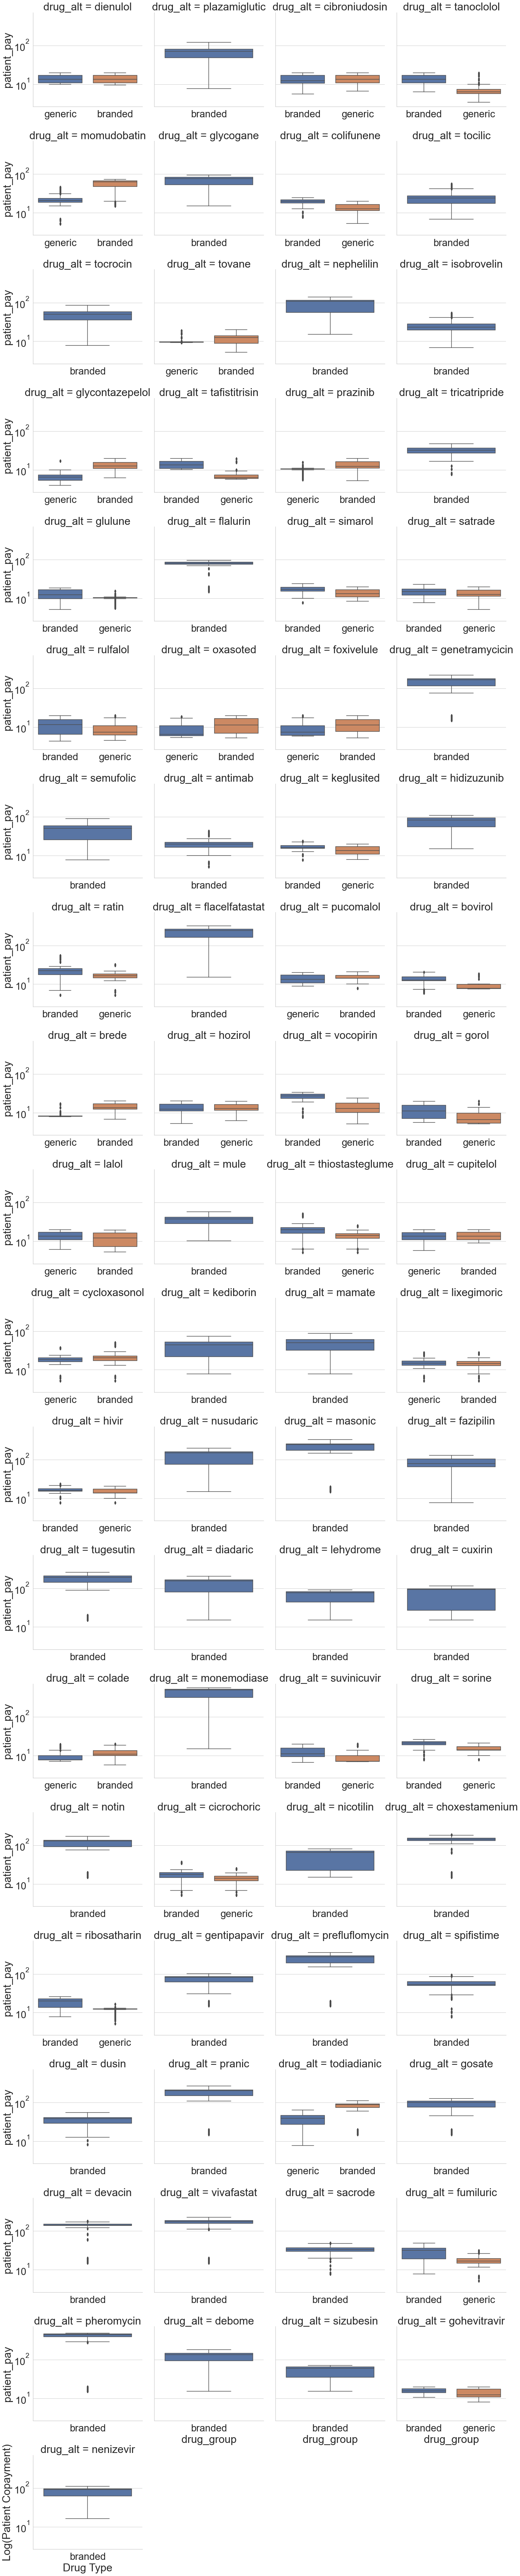

In [48]:
plot_data = \
    df_accepted \
    .assign(drug_alt = lambda x: x.drug.str.replace("generic|branded", "")) \
    .assign(drug_alt = lambda x: x.drug_alt.str.strip()) 

sns.catplot(
    x = "drug_group",
    y = "patient_pay",
    col = "drug_alt",
    kind = "box",
    col_wrap = 4,
    sharex = False,
    data = plot_data
).set(yscale = "log")
plt.xlabel("Drug Type")
plt.ylabel("Log(Patient Copayment)")

There are some drugs that don't have a generic option, but in every case the generics have lower copayments. 

Now we evaluate how copayments vary by generic status across diagnoses. 

There is only one diagnosis without a generic drug option and across the board, generic drugs have lower copayments. 

We can also examine the copayments for each drug within each broad diagnosis category. 

Here we see that there is a significant degree of variation in drug copayments across insurance plans.

## Summary of Patient Copayment EDA

The following patterns have emerged after exploring patient copayments:

1. The majority of claims are approved but there were no approved claims that had a \$0 copayment. In addition, all rejected claims had a \$0 copayment with no variation.

2. There is little to no variation in copayments over the course of the year. 

3. There is little to no variation in copayments across pharmacy locations. 

4. There is a small amount of variation in copayments across broad insurance plans and that variance increases with more detailed levels of insurance plan groups and pcns.

5. There is a substantial amount of variance in copayments across diagnosis type. 

6. Branded drugs have a slight majority over generics, and are always associated with higher copays. There is also a large amount of variance in copays across insurance plans for a given diagnosis. 

These findings indicated that broad and detailed insurance plan, drug type, and diagnosis will all be important predictors of patient copayments. 

### Suggested Preprocessing Steps

The following steps are recommended preprocessing steps:

1. Convert all categorical variables to dummy variables.

2. Log transform `patient_pay` to aid with computation.

3. Examine the interaction of `drug` and `diagnosis`, since copayments for drugs vary across diagnoses.

4. Examine the interaction of `diagnosis` and broad insurance plan, since copayments vary within each insurance plan for a given diagnosis. 

5. Explore PCA and regularization options. 